# Project 4: Poisonous Mushrooms

**Solution**

In this project, you'll investigate properties of mushrooms. This classic dataset contains over 8000 examples, where each describes a mushroom by a variety of features like color, odor, etc., and the target variable is an indicator for whether the mushroom is poisonous. The feature space has been binarized. Look at the feature_names below to see all 126 binary names.

You'll start by running PCA to reduce the dimensionality from 126 down to 2 so that you can easily visualize the data. In general, PCA is very useful for visualization (though sklearn.manifold.tsne is known to produce better visualizations). Recall that PCA is a linear transformation. The 1st projected dimension is the linear combination of all 126 original features that captures as much of the variance in the data as possible. The 2nd projected dimension is the linear combination of all 126 original features that captures as much of the remaining variance as possible. The idea of dense low dimensional representations is crucial to machine learning!

Once you've projected the data to 2 dimensions, you'll experiment with clustering using k-means and density estimation with Gaussian mixture models (GMM). Finally, you'll train a classifier by fitting a GMM for the positive class and a GMM for the negative class, and perform inference by comparing the probabilities output by each model.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please **prepare your own write-up and write your own code**.

## Grading
---
- Make sure to answer every part in every question.
 - There are 6 equally weighted questions.
 - Read carefully what is asked including the notes.
 - Additional points may be deducted if:
   - the code is not clean and well commented, 
   - and if the functions or answers are too long.

 ## Requirements:
---
1. Comment your code.
1. All graphs should have titles, label for each axis, and if needed a legend. It should be understandable on its own.
1. All code must run on colab.research.google.com
1. You should not import any additional libraries.
1. Try and minimize the use of the global namespace (meaning keep things in functions).

In [2]:
%matplotlib inline
import urllib.request as urllib2  # For python3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from matplotlib.colors import LogNorm
from matplotlib.patches import Circle
from scipy.spatial.distance import cdist

In [3]:
MUSHROOM_DATA = "https://raw.githubusercontent.com/UCB-MIDS/207-Applied-Machine-Learning/master/Data/mushroom.data"
MUSHROOM_MAP = "https://raw.githubusercontent.com/UCB-MIDS/207-Applied-Machine-Learning/master/Data/mushroom.map"

Load feature names.

In [4]:
feature_names = []

for line in urllib2.urlopen(MUSHROOM_MAP):
    [index, name, junk] = line.decode("utf-8").split()
    feature_names.append(name)

print("Loaded feature names: ", len(feature_names))
print(feature_names)

Loaded feature names:  126
['cap-shape=bell', 'cap-shape=conical', 'cap-shape=convex', 'cap-shape=flat', 'cap-shape=knobbed', 'cap-shape=sunken', 'cap-surface=fibrous', 'cap-surface=grooves', 'cap-surface=scaly', 'cap-surface=smooth', 'cap-color=brown', 'cap-color=buff', 'cap-color=cinnamon', 'cap-color=gray', 'cap-color=green', 'cap-color=pink', 'cap-color=purple', 'cap-color=red', 'cap-color=white', 'cap-color=yellow', 'bruises?=bruises', 'bruises?=no', 'odor=almond', 'odor=anise', 'odor=creosote', 'odor=fishy', 'odor=foul', 'odor=musty', 'odor=none', 'odor=pungent', 'odor=spicy', 'gill-attachment=attached', 'gill-attachment=descending', 'gill-attachment=free', 'gill-attachment=notched', 'gill-spacing=close', 'gill-spacing=crowded', 'gill-spacing=distant', 'gill-size=broad', 'gill-size=narrow', 'gill-color=black', 'gill-color=brown', 'gill-color=buff', 'gill-color=chocolate', 'gill-color=gray', 'gill-color=green', 'gill-color=orange', 'gill-color=pink', 'gill-color=purple', 'gill-col

Load data. The dataset is sparse, but there aren't too many features, so we'll use a dense representation, which is supported by all sklearn objects.

In [5]:
X, Y = [], []

for line in urllib2.urlopen(MUSHROOM_DATA):
    items = line.decode("utf-8").split()
    Y.append(int(items.pop(0)))
    x = np.zeros(len(feature_names))
    for item in items:
        feature = int(str(item).split(":")[0])
        x[feature] = 1
    X.append(x)

# Convert these lists to numpy arrays.
X = np.array(X)
Y = np.array(Y)

# Split into train and test data.
train_data, train_labels = X[:7000], Y[:7000]
test_data, test_labels = X[7000:], Y[7000:]

# Check that the shapes look right.
print(train_data.shape, test_data.shape)

(7000, 126) (1124, 126)


### Question 1:PCA and fraction of total variance
---

1. Do a principal components analysis on the data.
1. Print what fraction of the total variance in the training data is explained by the first k principal components, for k in [1, 2, 3, 4, 5, 10, 20, 30, 40, 50].
1. Show a lineplot of fraction of total variance vs. number of principal components, for all possible numbers of principal components.
1. You only need to call PCA.fit once.

Notes:
* The pandas DataFrame [cumsum](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.cumsum.html) function may be helpful.
* You can use `PCA` to produce a PCA analysis.

,num_components,Explained Fraction of Total Variance
0,1,0.164043
1,2,0.297278
2,3,0.399013
3,4,0.469646
4,5,0.508313
5,10,0.652215
6,20,0.808968
7,30,0.898549
8,40,0.950928
9,50,0.982103


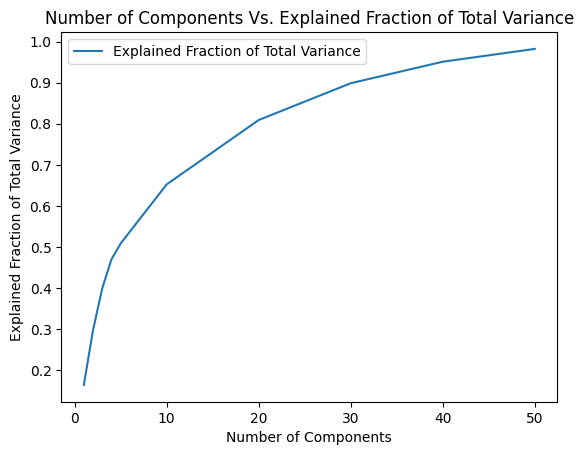

In [6]:
def P1():
    ## STUDENT START ###
    vals = {"num_components": [], "Explained Fraction of Total Variance": []}
    principal_comps = [1, 2, 3, 4, 5, 10, 20, 30, 40, 50]
    for pc in principal_comps:
        pca = PCA(n_components=pc)
        pca.fit(train_data)
        exp_var = pca.explained_variance_ratio_
    tot_exp_var = np.cumsum(exp_var, axis=0)
    for pc in principal_comps:
        vals["num_components"].append(pc)
        vals["Explained Fraction of Total Variance"].append(tot_exp_var[pc - 1])
    fin_df = pd.DataFrame(vals)
    fin_plt = fin_df.plot(
        x="num_components",
        y="Explained Fraction of Total Variance",
        kind="line",
        xlabel="Number of Components",
        ylabel="Explained Fraction of Total Variance",
        title="Number of Components Vs. Explained Fraction of Total Variance",
    )
    return fin_df

    ## STUDENT END ###


P1()

### Question 2: PCA for visualization

PCA can be very useful for visualizing data. 
1. Project the training data down to 2 dimensions and show as a square scatterplot.
  - Show poisonous examples (labeled 1) in red and non-poisonous examples in green (labeled 0)
  - Here's a reference for plotting: http://matplotlib.org/users/pyplot_tutorial.html

Notes:
* You can use `PCA` to produce a PCA analysis.
* Be sure to add a title, axis labels and a legend to your graph.

,pc1,pc2,label
0,-0.032993,-0.005971,1
1,-0.000067,-0.000162,0
2,-0.042133,0.035628,0
3,0.003555,0.038956,1
4,0.073107,-0.067036,0
...,...,...,...
121,-0.031867,-0.001451,0
122,0.101873,0.026451,0
123,-0.020841,-0.008932,0
124,-0.003054,-0.009892,0


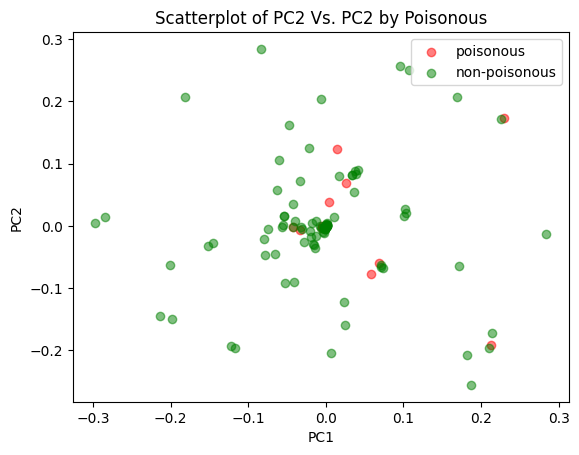

In [7]:
def Q2():
    ### STUDENT START ###
    pcs = {"pc1": [], "pc2": []}
    pca = PCA(n_components=2)
    components = pca.fit(train_data)
    pcs["pc1"] = components.components_[0]
    pcs["pc2"] = components.components_[1]
    pcs_df = pd.DataFrame(pcs)
    train_lab_df = pd.DataFrame({"label": train_labels[: len(pcs_df)]})
    final_df = pd.concat([pcs_df, train_lab_df], axis=1)
    # create scatterplot of first two PCs
    scatter1 = plt.scatter(
        x="pc1", y="pc2", c="r", data=final_df.loc[final_df["label"] == 1], alpha=0.5
    )
    scatter2 = plt.scatter(
        x="pc1", y="pc2", c="g", data=final_df.loc[final_df["label"] == 0], alpha=0.5
    )
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("Scatterplot of PC2 Vs. PC2 by Poisonous")

    # NEED TO FIGURE OT+UT LEGEND
    plt.legend(labels=["poisonous", "non-poisonous"])

    return final_df

    ### STUDENT END ###


Q2()

### Question 3: Visualizing GMMs
---

1. Fit a k-means cluster model with 6 clusters over the 2d projected data. 
  - As in part 2, show as a square scatterplot with the positive (poisonous) examples in red and the negative (non-poisonous) examples in green.  
  - For each cluster, mark the centroid and plot a circle that goes through the cluster's example that is most distant from the centroid.

Notes:
* You can use `KMeans` to produce a k-means cluster analysis.
* You can use `linalg.norm` to determine distance (dissimilarity) between observations.

c:\Users\evans\OneDrive\Documents\GitHub\mushroom-classifcation-pca\.venv\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,pc1,pc2
0,-0.032993,-0.005971
1,-0.000067,-0.000162
2,-0.042133,0.035628
3,0.003555,0.038956
4,0.073107,-0.067036
...,...,...
121,-0.031867,-0.001451
122,0.101873,0.026451
123,-0.020841,-0.008932
124,-0.003054,-0.009892


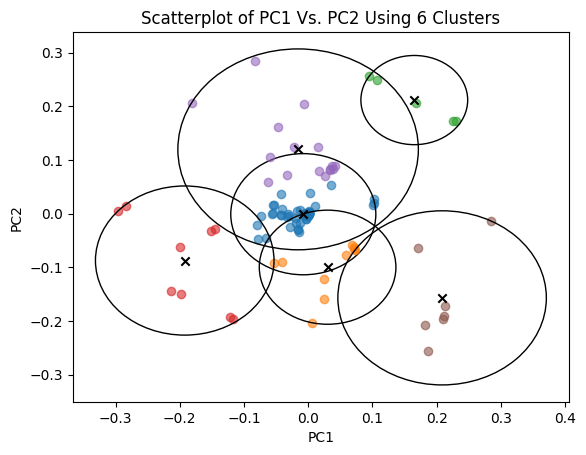

In [8]:
def Q3():
    ### STUDENT START ###
    # code for creating scatter plot
    pcs = {"pc1": [], "pc2": []}
    pca = PCA(n_components=2)
    components = pca.fit(train_data)
    pcs["pc1"] = components.components_[0]
    pcs["pc2"] = components.components_[1]
    pcs_df = pd.DataFrame(pcs)
    train_lab_df = pd.DataFrame({"label": train_labels[: len(pcs_df)]})
    final_df = pd.concat([pcs_df, train_lab_df], axis=1)

    # fitting KMeans algorithm to scatterplot data

    kmean = KMeans(n_clusters=6)
    pred_labels = kmean.fit_predict(pcs_df)
    centers = kmean.cluster_centers_
    unique_labels = np.unique(pred_labels)
    # create scatterplot of first two PCs
    display(pcs_df)
    for i in unique_labels:
        mask = np.where(pred_labels == i)[0]
        cluster_points = pcs_df.iloc[mask]
        center = centers[i]
        repeated_centers = [center for _ in range(len(cluster_points))]
        radius = max(cdist(repeated_centers, cluster_points.values)[0])
        plt.scatter(
            x=cluster_points.iloc[:, 0], y=cluster_points.iloc[:, 1], label=i, alpha=0.6
        )
        plt.scatter(center[0], center[1], label=i, marker="x", c="black")
        circle = Circle(center, radius, fill=False, linestyle="-", color="black")
        ax = plt.gca()
        ax.add_patch(circle)

    # plt.legend(labels=unique_labels)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("Scatterplot of PC1 Vs. PC2 Using 6 Clusters")

    ### STUDENT END ###


Q3()

### Question 4: Understanding GMMs with Density Plots
---

1. Fit Gaussian mixture models for the positive (poisonous) examples in your 2d projected data. 
  - Vary the number of mixture components from 1 to 4 and the covariance matrix type 'spherical', 'diag', 'tied', 'full' (that's 16 models).  
  - Show a 4x4 grid of square-shaped plots of the estimated density contours. 
    - Each row showing a different number of mixture components. 
    - Each column showing a different convariance matrix type.  
1. Be sure to add a title for each plot in the grid to indicate what parameters were used.
1. How are the covariance types 'tied' and 'full' different? How do you see it in the plots?

Notes:
* You can use `GaussianMixture(n_components=..., covariance_type=..., random_state=12345)` to produce a Gaussian mixture model.
* You can use `contour` in combination with other methods to plot contours, like in this example: http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html#example-mixture-plot-gmm-pdf-py
* You can use `contour` without the `norm` and `levels` parameters. 

c:\Users\evans\OneDrive\Documents\GitHub\mushroom-classifcation-pca\.venv\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
C:\Users\evans\AppData\Local\Temp\ipykernel_27320\1654313603.py:38: UserWarning: Log scale: values of z <= 0 have been masked
  CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0), levels=np.logspace(1, 3, 10))
c:\Users\evans\OneDrive\Documents\GitHub\mushroom-classifcation-pca\.venv\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
C:\Users\evans\AppData\Local\Temp\ipykernel_27320\1654313603.py:38: UserWarning: Log scale: values of z <= 0 have been masked
  CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0), levels=np.logspace(1, 3, 10))
c:\Users\evans\OneDrive\Documents\GitHub\mushroom-classifcation-pca\.venv\lib\site-packages\sklear

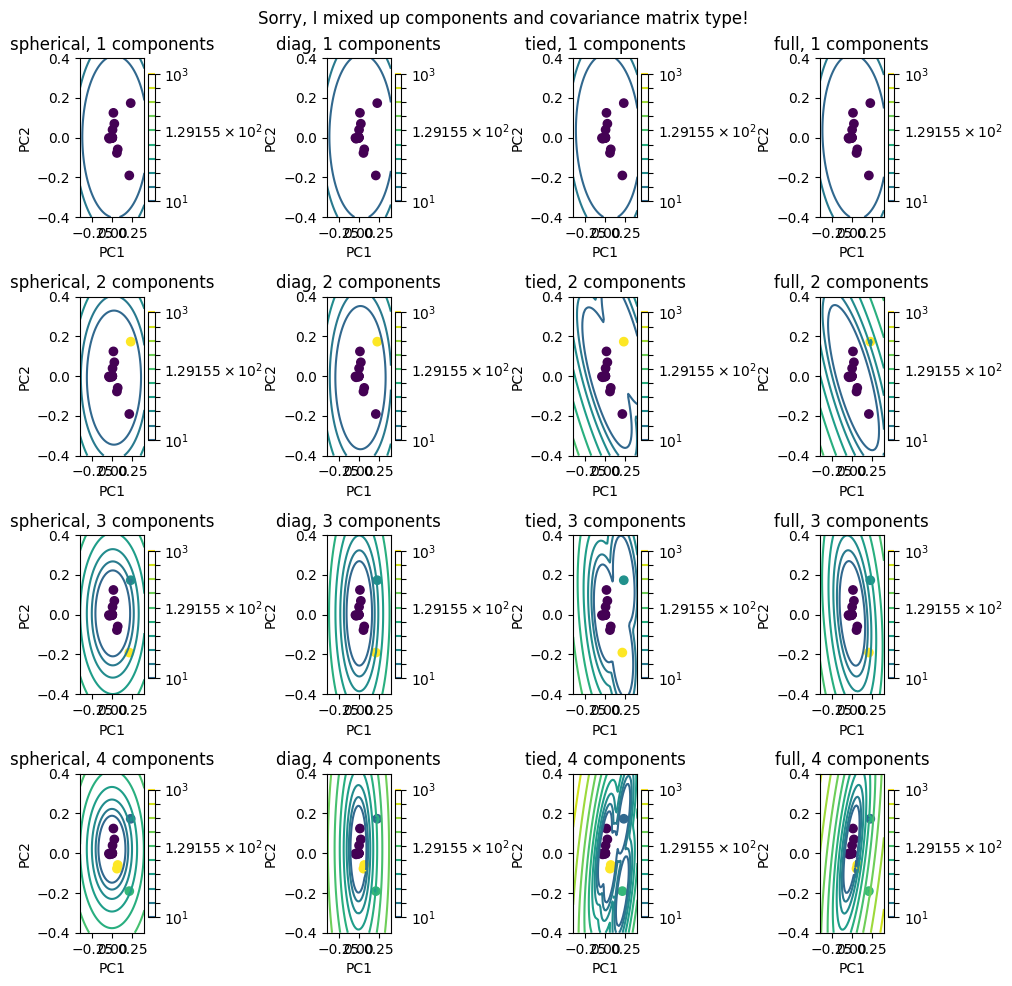

In [9]:
def Q4():
    ### STUDENT START ###
    pcs = {"pc1": [], "pc2": []}
    pca = PCA(n_components=2)
    components = pca.fit(train_data)
    pcs["pc1"] = components.components_[0]
    pcs["pc2"] = components.components_[1]
    pcs_df = pd.DataFrame(pcs)
    train_lab_df = pd.DataFrame({"label": train_labels[: len(pcs_df)]})
    final_df = pd.concat([pcs_df, train_lab_df], axis=1)
    poisonous_df = final_df[final_df["label"] == 1]
    poisonous_df_pcs = poisonous_df[["pc1", "pc2"]]

    # make GMM plots
    comps = range(1, 5)
    cov_mat = ["spherical", "diag", "tied", "full"]
    i = 0
    fig = plt.figure(figsize=(10, 10))
    for num in comps:
        for mat_type in cov_mat:
            gmm = GaussianMixture(
                n_components=num, covariance_type=mat_type, random_state=12345
            )
            gmm.fit(poisonous_df_pcs)
            y_hat = gmm.predict(poisonous_df_pcs)
            ax = fig.add_subplot(4, 4, i + 1)
            ax.scatter(poisonous_df.iloc[:, 0], poisonous_df.iloc[:, 1], c=y_hat)
            plt.title(f"{mat_type}, {num} components")
            plt.xlabel("PC1")
            plt.ylabel("PC2")
            
            x = np.linspace(-0.4, 0.4)
            y = np.linspace(-0.4, 0.4)
            X, Y = np.meshgrid(x, y)
            XX = np.array([X.ravel(), Y.ravel()]).T
            Z = -gmm.score_samples(XX)
            Z = Z.reshape(X.shape)
            CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0), levels=np.logspace(1, 3, 10))
            CB = plt.colorbar(CS, shrink=0.8)
            
            i += 1
    fig.suptitle("Sorry, I mixed up components and covariance matrix type!")
    fig.tight_layout(pad=1.0)
    ### STUDENT END ###


Q4()

Answer: Between the tied and full covariance matrix types for my Gaussian Mixture Model, it looks like the full covariance matrix model basically only looks at the first purple group and leaves the rest of the groups outside of the white region in the contour plot. The tied model does a much better job of segmenting groups as the number of components increases than the full model.

### Question 5: Using Unsupervised models for classification...?
---

1. Fit two Gaussian mixture models:
  - On your 2d projected training data. 
    - Form a subset of all the poisonous examples and fit one GMM (gmm_poison).
    - Form a subset of all the non-poisonous examples and fit another GMM (gmm_nonpoison).
  - Use 4 mixture components and full convariance for each model.  
1. Use the above trained GMMs to classify examples in your test set:
   - For each example in the test set
     - Measure how likely it is to have been "generated" by gmm_poison and gmm_nonpoison (using score_samples).
     - Predict the more likely label.
  - You can use score_samples.
  - You can do this without a for loop which will be more efficient.
1. What is the accuracy of the predictions on the test data? (we expect it to be about 0.95)

Notes:
* You can use `GaussianMixture(n_components=..., covariance_type=..., random_state=12345)` to produce a Gaussian mixture model.
* You can use `GaussianMixture`'s `score_samples` method to find the probabilities.

In [10]:
def split_poisonous(train_data, train_labels):
    xtrain_poison_idx = np.where(train_labels == 1)[0]
    xtrain_poison = train_data[xtrain_poison_idx]
    xtrain_nonpoison_idx = np.where(train_labels == 0)[0]
    xtrain_nonpoison = train_data[xtrain_nonpoison_idx]
    return (xtrain_poison, xtrain_nonpoison)


xtrain_poison, xtrain_nonpoison = split_poisonous(train_data, train_labels)


def Q5():
    ### STUDENT START ###

    xtrain_poison, xtrain_nonpoison = split_poisonous(train_data, train_labels)

    probas = []
    for data in [xtrain_poison, xtrain_nonpoison]:
        pca = PCA(n_components=2)
        pca.fit(data)
        pca_xtrain = pca.transform(data)
        pca_xtest = pca.transform(test_data)
        gmm = GaussianMixture(
            n_components=4, covariance_type="full", random_state=12345
        )
        gmm.fit(pca_xtrain)
        probas.append(gmm.score_samples(pca_xtest))

    probas = pd.DataFrame(
        np.array(probas).T, columns=["log proba poison", "log proba nonpoison"]
    )
    print(np.array(probas).T[0])
    probas["Predicted Poisonous"] = (
        probas["log proba poison"] > probas["log proba nonpoison"]
    ).astype(int)
    probas["test_data true labels"] = test_labels
    accuracy = np.mean(probas["Predicted Poisonous"] == probas["test_data true labels"])

    display(probas)

    return f"The accuracy of our GMM classifier was {accuracy}!"


tmp = Q5()
tmp

[ -9.61661709  -1.60629927 -13.37864177 ...  -3.17057043 -17.81520414
  -0.61413103]


,log proba poison,log proba nonpoison,Predicted Poisonous,test_data true labels
0,-9.616617,0.080882,0,0
1,-1.606299,-2.347607,1,0
2,-13.378642,-1.849221,0,0
3,-1.296767,-2.643299,1,1
4,-10.625450,-0.398661,0,0
...,...,...,...,...
1119,-13.344158,-3.161407,0,0
1120,-6.798006,-3.386028,0,0
1121,-3.170570,-3.691139,1,1
1122,-17.815204,-1.864542,0,0


'The accuracy of our GMM classifier was 0.9466192170818505!'

### Question 6: Understanding the GMM parameters
---

1. Run a series of experiments to find the Gaussian mixture model that results in the best accuracy with no more than 50 parameters.  Do this by varying the number of PCA components, the number of GMM components, and the covariance type.
1. Print the best configuration and accuracy.
1. Plot a scatter plot of accuracy vs #params.
1. Bonus: Provide a better visualization by showing all four: accuracy, number of parameters, the covariance type and the number of PCA dimensions.



Notes:
* You can use `GaussianMixture(n_components=..., covariance_type=..., random_state=12345)` to produce a Gaussian mixture model.
* [This spreadsheet](https://docs.google.com/spreadsheets/d/1LTEOU7q_Tgs4bX_3o2ePjDQrTRToZoc1J5XLlaRbmI0/edit?usp=sharing) should help (accessible from your google @berkeley.edu account)

* Spherical - Each GMM component has a mean per dimension, and one variance. 
* Diag - Each GMM component has a mean per dimension and a variance for each dimension.
* full - Each GMM component has a mean per dimension and a "full" covariance matrix. Only the covariance matrix is symmetric, so its $[i,j]$ entry would equal to its $[j,i]$ entry.
* tied - Finally, tied has all components share a single covariance matrix. So each GMM component has a mean per dimension but they all share the same 'full' covariance matrix.

,pca_num_components,covariance_matrix,gmm_num,accuracy,parameters
0,1,spherical,1,0.844306,4.0
1,1,spherical,2,0.898577,10.0
2,1,spherical,3,0.908363,16.0
3,1,diag,1,0.844306,4.0
4,1,diag,2,0.898577,10.0
5,1,diag,3,0.908363,16.0
6,1,tied,1,0.844306,4.0
7,1,tied,2,0.883452,8.0
8,1,tied,3,0.915480,12.0
9,1,full,1,0.844306,4.0


c:\Users\evans\OneDrive\Documents\GitHub\mushroom-classifcation-pca\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\evans\OneDrive\Documents\GitHub\mushroom-classifcation-pca\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\evans\OneDrive\Documents\GitHub\mushroom-classifcation-pca\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\evans\OneDrive\Documents\GitHub\mushroom-classifcation-pca\.venv\lib\site-pa

<Axes: title={'center': 'Accuracy vs. Parameters of GMM Model'}, xlabel='parameters', ylabel='accuracy'>

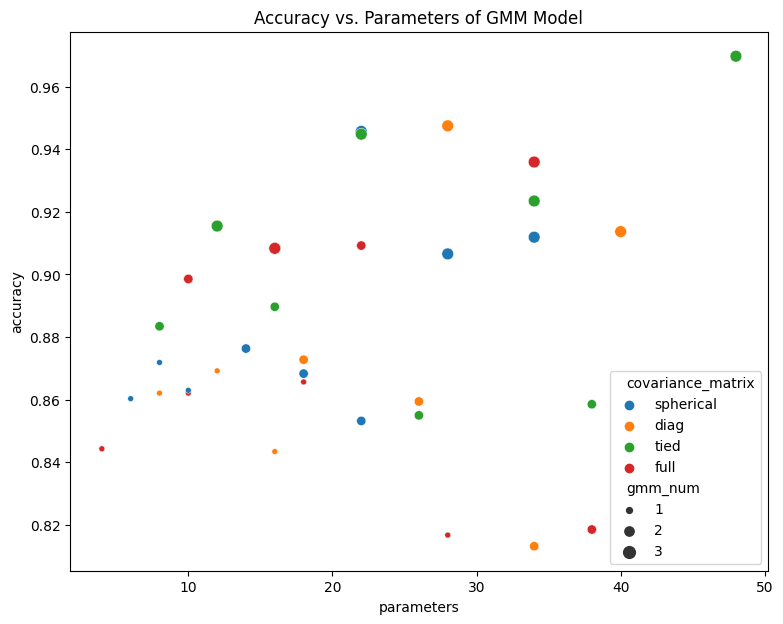

In [11]:
from matplotlib.lines import Line2D

def split_poisonous(train_data, train_labels):
    xtrain_poison_idx = np.where(train_labels == 1)[0]
    xtrain_poison = train_data[xtrain_poison_idx]
    xtrain_nonpoison_idx = np.where(train_labels == 0)[0]
    xtrain_nonpoison = train_data[xtrain_nonpoison_idx]
    return (xtrain_poison, xtrain_nonpoison)


xtrain_poison, xtrain_nonpoison = split_poisonous(train_data, train_labels)

def make_pca(components, train, test):
    pca = PCA(n_components=components)
    pca.fit(train)
    pca_xtrain = pca.transform(train)
    pca_xtest = pca.transform(test)
    return (pca_xtrain, pca_xtest)

def predict_gmm(gmm_num, cov, train, test):
    gmm = GaussianMixture(n_components=gmm_num, covariance_type= cov, random_state=12345)
    gmm.fit(train)
    #y_hat = gmm.predict(test)
    probabilities = gmm.score_samples(test)
    return probabilities

def calculate_accuracy(pred, true):
    return np.mean(pred == true)
    
def Q6():
    ### STUDENT START ###
    params = {'pca_num_components': [], 'covariance_matrix': [], 'gmm_num': [], 'accuracy': [], 'parameters': []}
    cov_mat = ["spherical", "diag", "tied", "full"]
    gmm_numbers = range(1,4)
    components = range(1,5)
    n_classes = 2
    for n_pca in components:
        # initialize pca models
        pca_train, pca_test = make_pca(n_pca, train_data, test_data)
        xtrain_poison, xtrain_nonpoison = split_poisonous(pca_train, train_labels)
        for matrix in cov_mat:
            for n_gmm in gmm_numbers:
                probas_poison = []
                probas_nonpoison = []
                probs_poison = predict_gmm(n_gmm, matrix, xtrain_poison, pca_test)
                probs_nonpoison = predict_gmm(n_gmm, matrix, xtrain_nonpoison, pca_test)
                probas_poison.append(probs_poison)
                probas_nonpoison.append(probs_nonpoison)
                predicted_poisonous = (probs_poison > probs_nonpoison).T.astype(int)
                accuracy = calculate_accuracy(predicted_poisonous, test_labels)
                params['accuracy'].append(accuracy)
                params['pca_num_components'].append(n_pca)
                params['covariance_matrix'].append(matrix)
                params['gmm_num'].append(n_gmm)
                if matrix == 'full':
                    param_count_full = ((n_gmm - 1) +n_pca*n_gmm + n_pca * (n_pca + 1)/ 2 * n_gmm) * n_classes
                    params['parameters'].append(param_count_full)
                elif matrix == 'diag':
                    param_count_diagonal = ((n_gmm - 1) + n_pca*n_gmm + n_pca * n_gmm) * n_classes
                    params['parameters'].append(param_count_diagonal)
                elif matrix == 'spherical':
                    param_count_spherical = ((n_gmm - 1) +n_pca*n_gmm + n_gmm) * n_classes
                    params['parameters'].append(param_count_spherical)
                else:
                    param_count_tied = ((n_gmm - 1) +n_pca*n_gmm + n_pca * (n_pca + 1)/ 2) * n_classes
                    params['parameters'].append(param_count_tied)
    final_df = pd.DataFrame(params)
    # making sure the parameters is restricted to less thamn 50 (to follow instructions)
    final_df = final_df.loc[final_df['parameters']<=50, :]
    display(final_df)
    fig_dims = (9,7)
    fig, ax = plt.subplots(figsize=fig_dims)
    scatter = sns.scatterplot(data = final_df, x = 'parameters', y = 'accuracy', hue = 'covariance_matrix', size = 'gmm_num')
    plt.title('Accuracy vs. Parameters of GMM Model')
    return scatter
    ### STUDENT END ###

Q6()

In [ ]:
np.mean(train_labels == 1)

0.45685714285714285

In [ ]:
test_labels

In [ ]:
np.mean(test_labels == 1)

0.6387900355871886

Comment: I noticed in the cells above that the distributions for the train_labels and test_labels are very different (46% of train_labels are poisonous vs. 64% of test_labels are poisionous). I feel like this is suspicious in determining good accuracy for our data.